This experimental notebook attempts to take the normalizing flow structure developed by Francois Lanusse in this notebook: https://github.com/EiffL/jax-nf/blob/master/notebooks/NSF.ipynb and apply it to our photo-z catalogs.

This first part is just running the pieces from the original notebook but training it with one color plus redshift as the two dimensions.

In [1]:
%pylab inline 

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../../../jax-nf/')

from tensorflow_probability.python.internal.backend import jax as tf
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax

Populating the interactive namespace from numpy and matplotlib


In [2]:
from jax_nf.real_nvp import RealNVP

In [3]:
from flax import nn
import jax
import jax.numpy as np
import numpy as onp
import flax 

tfb = tfp.bijectors
tfd = tfp.distributions

In [4]:
@nn.module
def NeuralSplineCoupling(x, nunits, nbins=32):

  def bin_positions(x):
    x = np.reshape(x, [-1, nunits, nbins])
    return nn.activation.softmax(x, axis=-1) *  (2. - nbins * 1e-2) + 1e-2
  
  def slopes(x):
    x = np.reshape(x, [-1, nunits, nbins - 1])
    return nn.activation.softplus(x) + 1e-2

  # Let's have one more non stupid layer
  net = nn.leaky_relu(nn.Dense(x, 128))
  net = nn.leaky_relu(nn.Dense(net, 128))

  bin_widths = bin_positions(nn.Dense(net, nunits*nbins))
  bin_heights = bin_positions(nn.Dense(net, nunits*nbins))
  knot_slopes = slopes(nn.Dense(net, nunits*(nbins-1)))

  return tfb.RationalQuadraticSpline(
            bin_widths=bin_widths,
            bin_heights=bin_heights,
            knot_slopes=knot_slopes)

In [5]:
# Instantiate the splines
d = 2
dummy_input = np.zeros((1, d//2))
_, params1 = NeuralSplineCoupling.init(jax.random.PRNGKey(0), dummy_input, d//2)

/astro/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [6]:
from functools import partial
spline1 = partial(NeuralSplineCoupling.call, params1)

In [7]:
nvp = tfd.TransformedDistribution(
        tfd.Normal(0,1),
        bijector=RealNVP(1, bijector_fn=spline1),
        event_shape=(2,))

In [8]:
samps = nvp.sample((1000,), seed=jax.random.PRNGKey(1))

/astro/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1531: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)
/astro/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/astro/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtyp

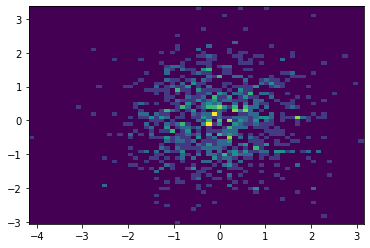

In [9]:
hist2d(samps[:,0], samps[:,1],64);

In [10]:
# Sweet :-D Hurray for TFP

In [11]:
# Let's try to learn a density

In [12]:
### Try to run with more than 2 dimensions now

In [78]:
d=6
@nn.module
def NeuralSplineFlow(x):
    
    spline1 = NeuralSplineCoupling.shared(name='spline1')
    spline2 = NeuralSplineCoupling.shared(name='spline2')
    
    # Computes the likelihood of these x
    chain = tfb.Chain([
        tfb.Scale(10),
        RealNVP(d//2, bijector_fn=spline1),
        tfb.Permute(np.arange(d)[::-1]),
        RealNVP(d//2, bijector_fn=spline2),
        tfb.Permute(np.arange(d)[::-1]),
        tfb.Scale(0.1)
    ])
    
    nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(d,))
    
    return nvp.log_prob(x)

In [79]:
dummy_input = np.zeros((1,d))
res, params = NeuralSplineFlow.init(jax.random.PRNGKey(0), dummy_input)

/astro/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/astro/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/astro/users/brycek/.conda/envs/py3

In [80]:
model = nn.Model(NeuralSplineFlow, params)

In [81]:
# Ok, sweet
@jax.jit
def train_step(optimizer, batch):
    
    def loss_fn(model):
        log_prob = model(batch['x'])
        return -np.mean(log_prob)
    
    loss, grad = jax.value_and_grad(loss_fn)(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return loss, optimizer

## Read in simulated data

Expensive to make but includes complex physical effects

In [82]:
from astropy.io import fits
import pandas as pd

In [83]:
hdulist = fits.open('/astro/store/epyc/users/brycek/DESC/Final_Buzzard_training_file.fits')

In [84]:
data_df = pd.DataFrame(hdulist[1].data)

In [85]:
data_df.head()

,BuzzID,oldID,ecatID,ra,dec,redshift,mstar,LSSTu,LSSTg,LSSTr,LSSTi,LSSTz,LSSTy,errLSSTu,errLSSTg,errLSSTr,errLSSTi,errLSSTz,errLSSTy
0,4,1868,265694,63.197601,-41.453098,0.038356,2.692900e+09,17.8313,16.9077,16.4431,16.2099,16.0613,15.8732,0.0050,0.0050,0.005,0.0050,0.0050,0.0050
1,14,25650,215939,63.153801,-40.588200,0.058309,1.315350e+10,19.0731,17.7448,16.9789,16.5288,16.2551,15.9531,0.0051,0.0050,0.005,0.0050,0.0050,0.0050
2,18,30908,494449,63.624401,-42.628899,0.063701,4.831440e+07,21.6380,21.0106,20.8286,20.6283,20.6552,20.5280,0.0068,0.0051,0.005,0.0051,0.0052,0.0064
3,21,34983,159487,63.646999,-42.124901,0.059006,2.670790e+08,20.5474,19.5542,19.2387,19.0568,19.0887,18.9865,0.0055,0.0050,0.005,0.0050,0.0050,0.0051
4,22,36218,273518,63.472801,-42.423302,0.063202,4.825270e+07,21.2378,20.6876,20.5661,20.4371,20.4799,20.4503,0.0061,0.0051,0.005,0.0051,0.0052,0.0063


In [86]:
# To get rid of byte order issue:
# (See https://pandas.pydata.org/pandas-docs/version/0.19.1/gotchas.html#byte-ordering-issues)

for column_name in data_df.columns:
    data_df[column_name] = data_df[column_name].values.byteswap().newbyteorder()

In [87]:
print(data_df.columns)

Index(['BuzzID', 'oldID', 'ecatID', 'ra', 'dec', 'redshift', 'mstar', 'LSSTu',
       'LSSTg', 'LSSTr', 'LSSTi', 'LSSTz', 'LSSTy', 'errLSSTu', 'errLSSTg',
       'errLSSTr', 'errLSSTi', 'errLSSTz', 'errLSSTy'],
      dtype='object')


## Clean up data and prepare training catalog

From our scatter plot we can see that missing data is recorded as 99. Let's only take values where we have all the magnitudes for the galaxy.

Text(0, 0.5, 'LSSTg')

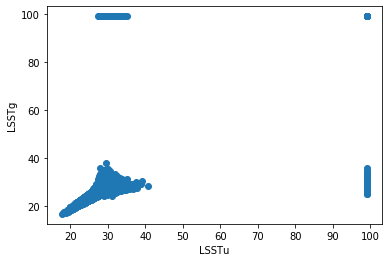

In [23]:
plt.scatter(data_df['LSSTu'], data_df['LSSTg'])
plt.xlabel('LSSTu')
plt.ylabel('LSSTg')

In [24]:
clean_data_df = data_df.query('%s < 90. and %s < 90. and %s < 90. and %s < 90. and %s < 90. and %s < 90.' % ('LSSTu',
                                                                                                             'LSSTg',
                                                                                                             'LSSTr',
                                                                                                             'LSSTi',
                                                                                                             'LSSTz',
                                                                                                             'LSSTy'))

In [25]:
clean_data_df = clean_data_df.reset_index(drop=True)

In [26]:
clean_data_df.head()

,BuzzID,oldID,ecatID,ra,dec,redshift,mstar,LSSTu,LSSTg,LSSTr,LSSTi,LSSTz,LSSTy,errLSSTu,errLSSTg,errLSSTr,errLSSTi,errLSSTz,errLSSTy
0,4,1868,265694,63.197601,-41.453098,0.038356,2.692900e+09,17.8313,16.9077,16.4431,16.2099,16.0613,15.8732,0.0050,0.0050,0.005,0.0050,0.0050,0.0050
1,14,25650,215939,63.153801,-40.588200,0.058309,1.315350e+10,19.0731,17.7448,16.9789,16.5288,16.2551,15.9531,0.0051,0.0050,0.005,0.0050,0.0050,0.0050
2,18,30908,494449,63.624401,-42.628899,0.063701,4.831440e+07,21.6380,21.0106,20.8286,20.6283,20.6552,20.5280,0.0068,0.0051,0.005,0.0051,0.0052,0.0064
3,21,34983,159487,63.646999,-42.124901,0.059006,2.670790e+08,20.5474,19.5542,19.2387,19.0568,19.0887,18.9865,0.0055,0.0050,0.005,0.0050,0.0050,0.0051
4,22,36218,273518,63.472801,-42.423302,0.063202,4.825270e+07,21.2378,20.6876,20.5661,20.4371,20.4799,20.4503,0.0061,0.0051,0.005,0.0051,0.0052,0.0063


Create a training dataset only consisting of photometric information and redshift.

In [27]:
train_df = clean_data_df[['redshift', 'LSSTu', 'LSSTg', 'LSSTr', 'LSSTi', 'LSSTz', 'LSSTy',
                          'errLSSTu', 'errLSSTg', 'errLSSTr', 'errLSSTi', 'errLSSTz', 'errLSSTy']]

In [28]:
train_df.head()

,redshift,LSSTu,LSSTg,LSSTr,LSSTi,LSSTz,LSSTy,errLSSTu,errLSSTg,errLSSTr,errLSSTi,errLSSTz,errLSSTy
0,0.038356,17.8313,16.9077,16.4431,16.2099,16.0613,15.8732,0.0050,0.0050,0.005,0.0050,0.0050,0.0050
1,0.058309,19.0731,17.7448,16.9789,16.5288,16.2551,15.9531,0.0051,0.0050,0.005,0.0050,0.0050,0.0050
2,0.063701,21.6380,21.0106,20.8286,20.6283,20.6552,20.5280,0.0068,0.0051,0.005,0.0051,0.0052,0.0064
3,0.059006,20.5474,19.5542,19.2387,19.0568,19.0887,18.9865,0.0055,0.0050,0.005,0.0050,0.0050,0.0051
4,0.063202,21.2378,20.6876,20.5661,20.4371,20.4799,20.4503,0.0061,0.0051,0.005,0.0051,0.0052,0.0063


In [29]:
train_df.sample(n=512, replace=False)

,redshift,LSSTu,LSSTg,LSSTr,LSSTi,LSSTz,LSSTy,errLSSTu,errLSSTg,errLSSTr,errLSSTi,errLSSTz,errLSSTy
30231,0.767267,28.7934,29.7792,27.1004,26.0042,25.6821,24.9587,1.5516,0.4148,0.1376,0.0985,0.1355,0.3086
17167,1.353000,26.6433,26.4916,26.3806,26.2206,25.9723,25.7056,0.3848,0.1038,0.0792,0.1115,0.1615,0.2836
89645,0.709350,27.8929,26.2767,24.6314,23.4045,22.9196,22.5428,0.7302,0.0750,0.0160,0.0106,0.0130,0.0267
9302,0.694381,26.0733,25.4695,24.5690,23.8330,23.5831,23.4833,0.2224,0.0376,0.0152,0.0144,0.0228,0.0568
62043,0.347088,29.0248,27.1551,26.8133,26.7420,26.7213,26.3856,0.7184,0.1902,0.1029,0.1768,0.2797,0.7436
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12206,0.887679,28.3431,27.5844,26.8254,26.4184,26.0072,26.1102,0.7071,0.2090,0.1254,0.1327,0.1995,0.4925
15532,1.158820,28.5088,28.6711,27.4427,26.9682,26.6679,26.2162,0.7538,0.2567,0.1991,0.3071,0.4086,0.8813
89268,0.690612,26.7571,27.4024,27.1800,26.9925,26.5147,26.9324,0.6019,0.2113,0.1570,0.2309,0.4059,0.9787
7583,0.616176,28.5478,27.7164,26.9571,25.9296,26.0581,25.5273,1.2724,0.2745,0.1070,0.1086,0.1739,0.3954


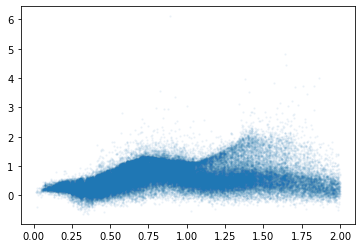

In [30]:
plt.scatter(train_df['redshift'], train_df['LSSTr']-train_df['LSSTi'], s=2, alpha=0.05)

In [31]:
### Set up 3-d training set

In [88]:
# Experimenting with only a fixed number of points
batch_size=512
def get_batch():
    rand_select = train_df.sample(n=2048, replace=False)
    x = np.array([rand_select['redshift'].values, 
                  rand_select['LSSTu'].values - rand_select['LSSTg'].values,
                  rand_select['LSSTg'].values - rand_select['LSSTr'].values, 
                  rand_select['LSSTr'].values - rand_select['LSSTi'].values,
                  rand_select['LSSTi'].values - rand_select['LSSTz'].values,
                  rand_select['LSSTz'].values - rand_select['LSSTy'].values])
    x = x.T
    return {'x': x}

In [89]:
get_batch()

{'x': DeviceArray([[ 1.42843 ,  1.3524  ,  1.0539  ,  1.8998  ,  0.6982  ,
                1.0014  ],
              [ 0.777036,  0.453   ,  1.3979  ,  1.2635  ,  0.572   ,
                0.4018  ],
              [ 0.798511, -0.5547  ,  1.6444  ,  1.0653  ,  0.5252  ,
                0.3274  ],
              ...,
              [ 0.61191 ,  0.7824  ,  0.4743  ,  1.0325  ,  0.3465  ,
                0.4021  ],
              [ 1.93863 ,  0.117   ,  0.2727  ,  0.1127  ,  0.4204  ,
               -0.3632  ],
              [ 1.05567 , -1.4255  ,  2.0532  ,  0.4197  ,  0.9732  ,
                0.4732  ]], dtype=float32)}

In [90]:
# okokokok, let's try it out
optimizer = flax.optim.Adam(learning_rate=0.001).create(model)
losses = []

In [94]:
for i in range(2000):
    batch = get_batch()
    l, optimizer = train_step(optimizer, batch)
    losses.append(l)
    if  i % 100 == 0:
        print(l)

1.2238581
1.2776425
1.1167749
1.3082299
1.2279508
1.1822537
1.1936731
1.2254754
1.1300886
1.2230291
1.0517633
1.1741059
1.2475656
1.0254233
1.3055739
1.1456206
1.2175977
1.1219355
1.1453333
1.1699455


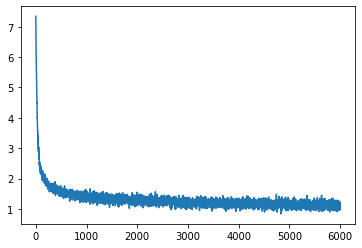

In [95]:
plot(losses)

In [37]:
### Looks like the model trained successfully for 3 dimensions
### Now let's try to sample

In [96]:
d=6
@nn.module
def NeuralSplineFlow(x):
    
    spline1 = NeuralSplineCoupling.shared(name='spline1')
    spline2 = NeuralSplineCoupling.shared(name='spline2')
    
    # Computes the likelihood of these x
    chain = tfb.Chain([
        tfb.Scale(10),
        RealNVP(d//2, bijector_fn=spline1),
        tfb.Permute(np.arange(d)[::-1]),
        RealNVP(d//2, bijector_fn=spline2),
        tfb.Permute(np.arange(d)[::-1]),
        tfb.Scale(0.1)
    ])
    
    nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(d,))
    
    return nvp.log_prob(x)

In [97]:
# ok, fine, let's see if we can rebuild our flow
@nn.module
def NeuralSplineFlowSampler(key, n_samples):
    
    spline1 = NeuralSplineCoupling.shared(name='spline1')
    spline2 = NeuralSplineCoupling.shared(name='spline2')
    
    # Computes the likelihood of these x
    chain = tfb.Chain([
        tfb.Scale(10),
        RealNVP(d//2, bijector_fn=spline1),
        tfb.Permute(np.arange(d)[::-1]),
        RealNVP(d//2, bijector_fn=spline2),
        tfb.Permute(np.arange(d)[::-1]),
        tfb.Scale(0.1)
    ])
    nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(d,))
    
    return nvp.sample(n_samples, seed=key)

In [98]:
sampler = nn.Model(NeuralSplineFlowSampler, optimizer.target.params)

In [99]:
samps = sampler(jax.random.PRNGKey(1),40000)

/astro/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1531: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)
/astro/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/astro/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtyp

In [100]:
### Uh-oh!

In [101]:
samps

DeviceArray([[ 0.6635891 ,  0.03620924,  0.4739753 ,  0.4087518 ,
               0.13734916,  0.27423766],
             [ 0.5820622 ,  0.11645877,  0.8900417 ,  0.73682934,
               0.11754189,  0.00804156],
             [ 0.8407744 ,  0.6459436 ,  0.98144084,  0.9568784 ,
               0.35486352,  0.29310587],
             ...,
             [ 0.2814779 ,  0.87752014,  0.6285885 ,  0.17547533,
              -0.13651475,  0.64837337],
             [ 1.0626311 , -0.37803861, -0.5089491 ,  2.0444245 ,
               0.10206621,  0.9177094 ],
             [ 0.7074147 , -0.26878408,  0.72058606,  0.6581042 ,
              -0.10695559, -1.4932805 ]], dtype=float32)

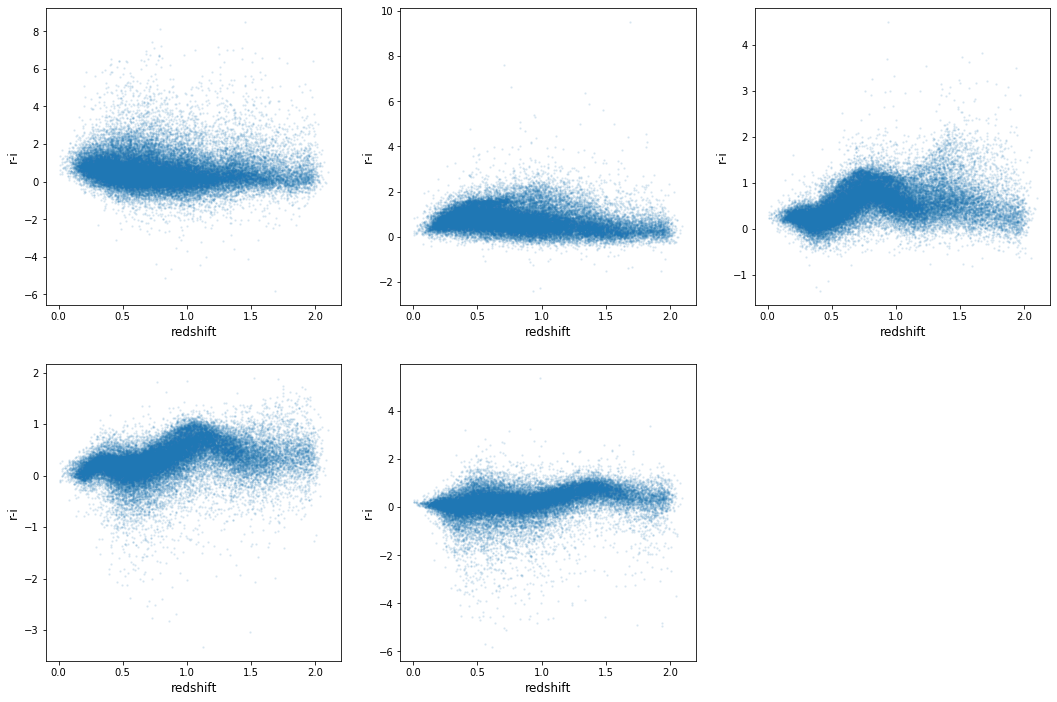

In [311]:
fig = plt.figure(figsize=(18,12))
for i in range(1,6):
    fig.add_subplot(2,3,i)
    plt.scatter(samps[:,0], samps[:,i], s=2, alpha=0.1)
#     plt.xlim(0, 2)
#     plt.ylim(0, 2)
    plt.xlabel('redshift', size=12)
    plt.ylabel('r-i', size=12)

Text(0, 0.5, 'r-i')

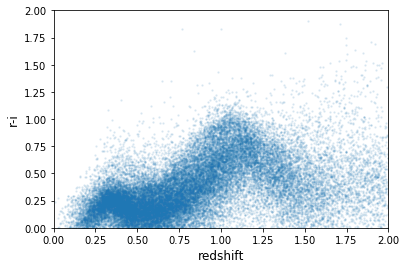

In [308]:
plt.scatter(samps[:,0], samps[:,4], s=2, alpha=0.1)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel('redshift', size=12)
plt.ylabel('r-i', size=12)

Text(0, 0.5, 'r-i')

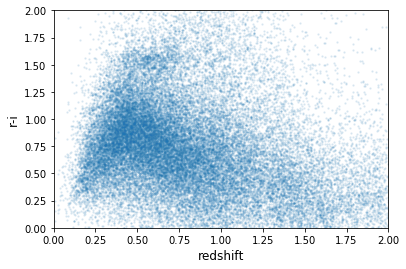

In [105]:
plt.scatter(samps[:,0], samps[:,2], s=2, alpha=0.1)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel('redshift', size=12)
plt.ylabel('r-i', size=12)

Text(0, 0.5, 'r-i')

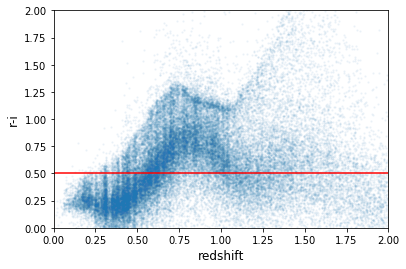

In [106]:
plt.scatter(train_df['redshift'][::2], train_df['LSSTr'][::2]-train_df['LSSTi'][::2], s=2, alpha=0.05)
plt.axhline(.5, c='r')
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel('redshift', size=12)
plt.ylabel('r-i', size=12)

Text(0, 0.5, 'g-r')

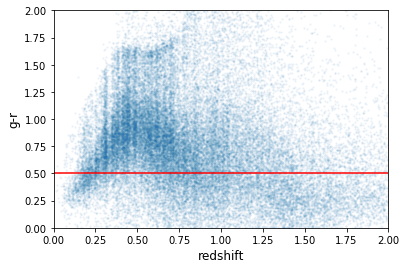

In [107]:
plt.scatter(train_df['redshift'][::2], train_df['LSSTg'][::2]-train_df['LSSTr'][::2], s=2, alpha=0.05)
plt.axhline(.5, c='r')
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel('redshift', size=12)
plt.ylabel('g-r', size=12)

### Use normalizing flow result to create p(z | color).

Now we want to adapt the normalizing flow for our problem. We need to be able to get the probability for specific color-redshift locations. If we do this for a range of redshifts at the same color we can get a conditional probability distribution for p(z | color).

In [109]:
nvp.log_prob??

Signature: nvp.log_prob(value, name='log_prob', **kwargs)
Source:   
  def log_prob(self, value, name='log_prob', **kwargs):
    """Log probability density/mass function.

    Args:
      value: `float` or `double` `Tensor`.
      name: Python `str` prepended to names of ops created by this function.
      **kwargs: Named arguments forwarded to subclass implementation.

    Returns:
      log_prob: a `Tensor` of shape `sample_shape(x) + self.batch_shape` with
        values of type `self.dtype`.
    """
    return self._call_log_prob(value, name, **kwargs)
File:      ~/.conda/envs/py3-bryce/lib/python3.7/site-packages/tensorflow_probability/python/distributions/_jax/distribution.py
Type:      method


In [110]:
# ok, fine, let's see if we can rebuild our flow
@nn.module
def NeuralSplineFlowLogProb(point):
    
    spline1 = NeuralSplineCoupling.shared(name='spline1')
    spline2 = NeuralSplineCoupling.shared(name='spline2')
    
    # Computes the likelihood of these x
    chain = tfb.Chain([
        tfb.Scale(10),
        RealNVP(d//2, bijector_fn=spline1),
        tfb.Permute(np.arange(d)[::-1]),
        RealNVP(d//2, bijector_fn=spline2),
        tfb.Permute(np.arange(d)[::-1]),
        tfb.Scale(0.1)
    ])
    nvp = tfd.TransformedDistribution(
                tfd.Normal(0,1),
                bijector=chain,
                event_shape=(d,))
    
    return nvp.log_prob(point)

In [111]:
log_prob_return = nn.Model(NeuralSplineFlowLogProb, optimizer.target.params)

In [112]:
log_prob_return([[.25, .25, .25, 
                  .25, .25, .25]])

DeviceArray([-3.5101085], dtype=float32)

In [374]:
# What is probability density function of redshift given r-i = 1.
redshift_color_points = []
for i in np.arange(0., 2.01, 0.01):
    redshift_color_points.append([i, .3, .5, .5, .5, .5])
log_prob_result = log_prob_return(redshift_color_points)

/astro/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/astro/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/astro/users/brycek/.conda/envs/py3

In [375]:
prob_result = np.exp(log_prob_result)

Text(0.5, 1.0, 'P(z | (u-g, g-r, r-i, i-z, z-y) =(.5, .5, .5, .5, .5))')

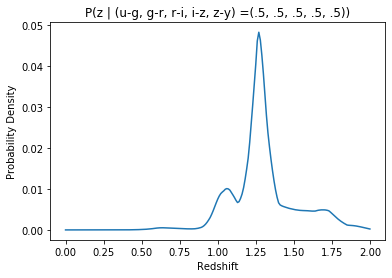

In [376]:
plt.plot(np.arange(0., 2.01, 0.01), prob_result/np.sum(prob_result))
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('P(z | (u-g, g-r, r-i, i-z, z-y) =(.5, .5, .5, .5, .5))')

In [377]:
approx_df = train_df.query('LSSTu - LSSTg > 0.2 and ' +
                           'LSSTu - LSSTg < 0.4 and ' +
                           'LSSTg - LSSTr > 0.4 and ' +
                           'LSSTg - LSSTr < 0.6 and ' +
                           'LSSTr - LSSTi > 0.4 and ' +
                           'LSSTr - LSSTi < 0.6 and ' +
                           'LSSTi - LSSTz > 0.4 and ' +
                           'LSSTi - LSSTz < 0.6 and ' +
                           'LSSTz - LSSTy > 0.4 and ' +
                           'LSSTz - LSSTy < 0.6')

In [378]:
len(approx_df)

48

(0, 2)

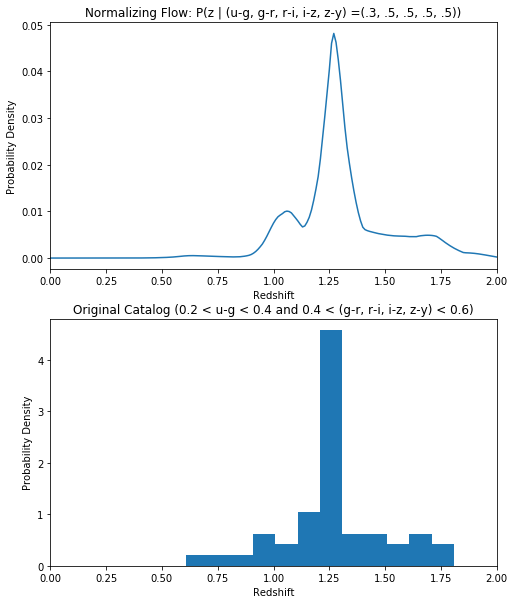

In [379]:
fig = plt.figure(figsize=(8, 10))
fig.add_subplot(2,1,1)
plt.plot(np.arange(0., 2.01, 0.01), prob_result/np.sum(prob_result))
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Normalizing Flow: P(z | (u-g, g-r, r-i, i-z, z-y) =(.3, .5, .5, .5, .5))')
plt.xlim(0, 2.)
fig.add_subplot(2,1,2)
plt.hist(approx_df['redshift'], bins=12, density=True)
plt.xlabel('Redshift')
plt.ylabel('Probability Density')
plt.title('Original Catalog (0.2 < u-g < 0.4 and 0.4 < (g-r, r-i, i-z, z-y) < 0.6)')
plt.xlim(0,2)